# Sequence Training Example:  Predicting the mood swings of a retired lab rat
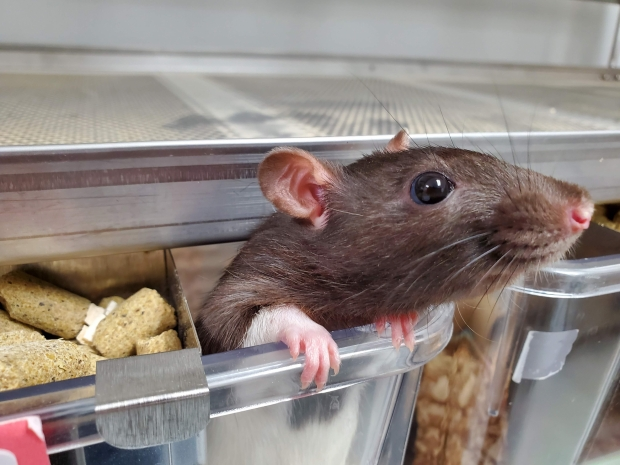

This is a very simple example of using an LSTM to predict a time-varying target value in a time series in tensorflow. 

* This notebook was inspired by https://www.justintodata.com/forecast-time-series-lstm-with-tensorflow-keras/

Author: Rasmus F. Ørsøe<br>
Date: 12th of May 2021!

# Background:
Suppose that we had rescued a retired lab rat Linux and found that the stress of lab life had taken it's toll on him. Specificly, we've observed that Linux have quite severe mood swings and we need to be careful when we feed him.  We've just managed to put together a device that lets us monitor his mood, so now we need to be able to predict in which mood Linux is sometime in the future, such that we can decide whether it is a safe time to feed him or not. As always, we begin by importing relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

Here we construct the simple time series representing the mood swings of Linux:

In [2]:
time_step_size  = 0.1 # amount of seconds between steps
time_end        = 1000
delta           = 0.02
time_series     = np.arange(0,time_end,time_step_size)
measurement     = np.sin(time_series*delta)


data = pd.DataFrame()
data['time'] = time_series
data['measurement'] = measurement 


Let's plot his mood, just to get a gauge on what kind of lab rat we're working with:

(0.0, 1000.0)

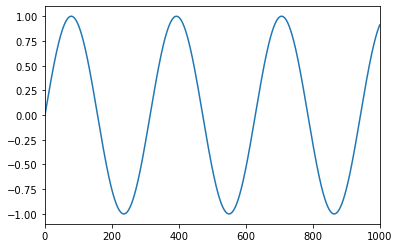

In [3]:
plt.plot(data['time'],data['measurement'])
plt.xlim(0,1000)

Yikes!

### Preprocessing
Here I use sklearn.preprocessing.RobustScaler() to transform the data 

In [4]:
scaler_time = RobustScaler().fit(np.array(data['time']).reshape(-1,1))
scaler_measurement = RobustScaler().fit(np.array(data['measurement']).reshape(-1,1))

data['time'] = scaler_time.transform(np.array(data['time']).reshape(-1,1))
data['measurement'] = scaler_measurement.transform(np.array(data['measurement']).reshape(-1,1))

Now we're at a crucial step; creating sequences from the data. An LSTM is a recurrent neural network (RNN) and these require the input to come in a specific format; a sequence. This is the most tricky part to wrap your head around. Let's start with the dimensions of the input data, before explaining what a sequence is.  Generally, the dimensions of the input needs to be on the form 
* input.shape = (number_of_sequences, number_of_time_steps_in_a_single_sequence, n_features_in_a_sequence)

So what is a sequence? For a time series forecast, like the one we're doing for Linux, we want to feed the LSTM the past observations such that it can predict future observations. 
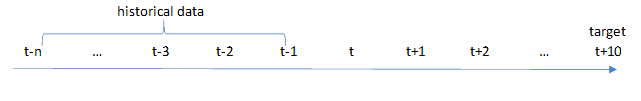

So if the time is t, we want to feed the LSTM the past t-n time steps in order to forecast/predict the future observation at time t+forecast_horizon. This means that the sequence is the past t-n observations. Here n denotes the number of time steps we allow the model to see in the past.


For this little example, I'll choose n=sequence_length=250 and forecast_horizon = 10. 

This means that our LSTM will see the 'current' time step and the previous 249 steps and on the basis of these predict the value that is 10 steps in the future. We then shift the 'current' time step forward by 1 step and create the next sequence and repeat this.

In [5]:
sequence_length = 250 # the length of the sequence we will produce
forecast_horizon= 10  # the timestep in the 'future' that we wish to predict.  

series_x = []
series_y = []


for t in range(sequence_length,(len(data)-forecast_horizon), 1): ## Our t starts at t = sequence_length = 100
    series_x.append(np.array(data[['time','measurement']][(t - sequence_length):t])) # here we select the time and the measurement from the past t-sequence_length observations
    series_y.append(data['measurement'][t+forecast_horizon])# here we select the observed measurement at t+forecast_horizon in the future
series_x = np.array(series_x)
series_y = np.array(series_y)
    
    
print('dimensions of input:')
print(series_x.shape)
print('-------------')
print('dimension of truth:')
print(series_y.shape)
print('-------------')
print('total number of time steps in data:')
print((len(data)))

dimensions of input:
(9740, 250, 2)
-------------
dimension of truth:
(9740,)
-------------
total number of time steps in data:
10000


So as you can see, from a time series of a total of 10.000 steps, we create 9740 sequences, each with 250 steps in them and 2 features; time and measurement. Why is there only 9740 sequences and not 10000? Because we start at t = sequence_length = 250, and we must stop at t=len(data) - forecast_horizon. So n_sequences = len(data) -  forecast_horizon - sequence_length = 10000 - 10 - 250 = 9740.


OK. Now let's do a train/validation split! <br>


In [6]:
series_x_train, series_x_valid, series_y_train, series_y_valid = train_test_split(series_x, series_y, test_size=0.33, random_state=42)

Let's plot a few of the sequences and the truth values!

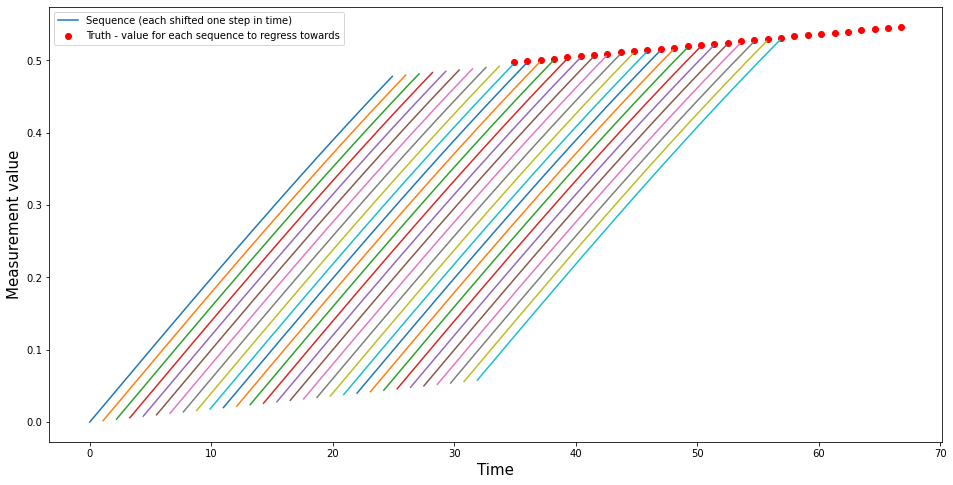

In [7]:
fig = plt.figure(figsize=(16,8))
#print(series_x[0])

for k in range(0,30):
    if k == 0:
        plt.plot(scaler_time.inverse_transform(series_x[k][:,0].reshape(-1,1))+k,scaler_measurement.inverse_transform(series_x[k][:,1].reshape(-1,1)), label ='Sequence (each shifted one step in time)')
        plt.scatter(scaler_time.inverse_transform(series_x[k][-1,0].reshape(-1,1))+forecast_horizon+k, scaler_measurement.inverse_transform(series_y[k].reshape(-1,1)), color = 'red', label = 'Truth - value for each sequence to regress towards')
    else:
        plt.plot(scaler_time.inverse_transform(series_x[k][:,0].reshape(-1,1))+k,scaler_measurement.inverse_transform(series_x[k][:,1].reshape(-1,1)))
        plt.scatter(scaler_time.inverse_transform(series_x[k][-1,0].reshape(-1,1))+forecast_horizon+k, scaler_measurement.inverse_transform(series_y[k].reshape(-1,1)), color = 'red')

plt.xlabel('Time', size  = 15)
plt.ylabel('Measurement value', size  = 15)
plt.legend()

Now check by eye: is there 10 timesteps between the first sequence and the first target value? Would you expect the sequence to look sine-like when the sequence length is just 250? (You can vary sequence_length to check this!)

### Training

Now we're ready to define the model:

In [8]:

ts_inputs = tf.keras.Input(shape=(sequence_length, 2))
# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
x = layers.LSTM(units=10)(ts_inputs)
x = layers.Dropout(0.01)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)



2022-06-06 18:24:55.427297: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we're ready to train!

In [9]:
learning_rate = 1e-3
n_epochs = 3
batch_size = 50
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model.fit(x=series_x_train, y=series_y_train, batch_size=batch_size, validation_data = (series_x_valid,series_y_valid), epochs = n_epochs)


Epoch 1/3
131/131 [==============================] - 9s 53ms/step - loss: 0.0996 - mse: 0.0996 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 2/3
131/131 [==============================] - 7s 51ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/3
131/131 [==============================] - 7s 52ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 6.6889e-04 - val_mse: 6.6889e-04


### Inspecting results/predictions:

In [10]:
predictions = model.predict(x = series_x_valid)

Let's try and plot the predictions with the truth as a function of time:

Text(0, 0.5, 'Measurement')

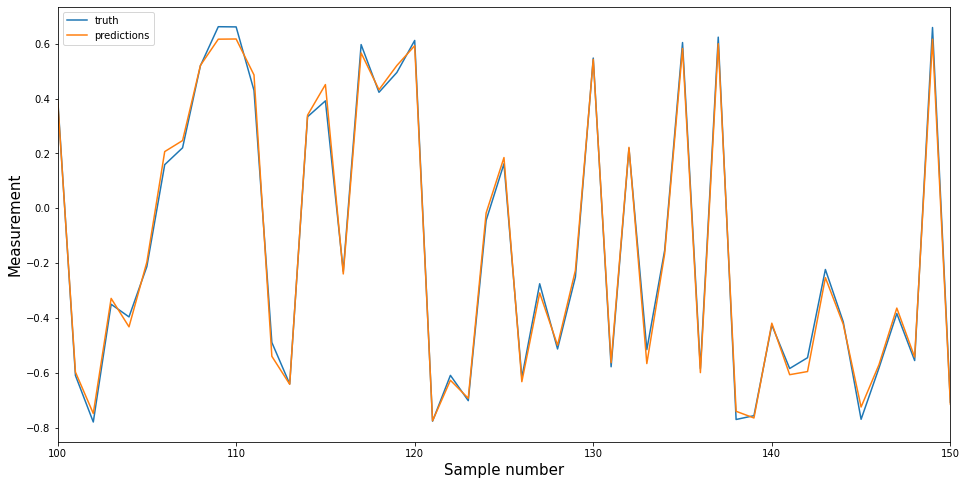

In [11]:
fig = plt.figure(figsize=(16,8))
plt.plot(series_y_valid,label = 'truth')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.xlim(100,150)
plt.xlabel('Sample number', size = 15)
plt.ylabel('Measurement', size = 15)

Seems like a decent fit. Let's try to plot the truth vs predicted in a 2D histogram! (we're hoping for a straight line on the form y=1x+0)

Text(0, 0.5, 'Predicted value')

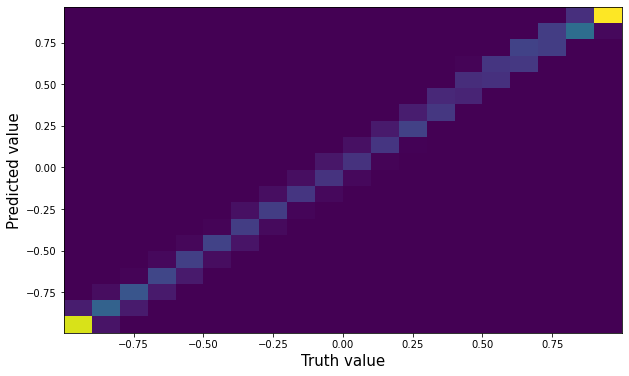

In [12]:
fig = plt.figure(figsize=(10,6))
plt.hist2d(scaler_measurement.inverse_transform(series_y_valid.reshape(-1,1))[:,0],scaler_measurement.inverse_transform(predictions[:,0].reshape(-1,1))[:,0], bins = 20)
plt.xlabel('Truth value', size = 15)
plt.ylabel('Predicted value', size = 15)

Not great but not terrible either! Let's have a look at the 1D distribution of truth and predictions:

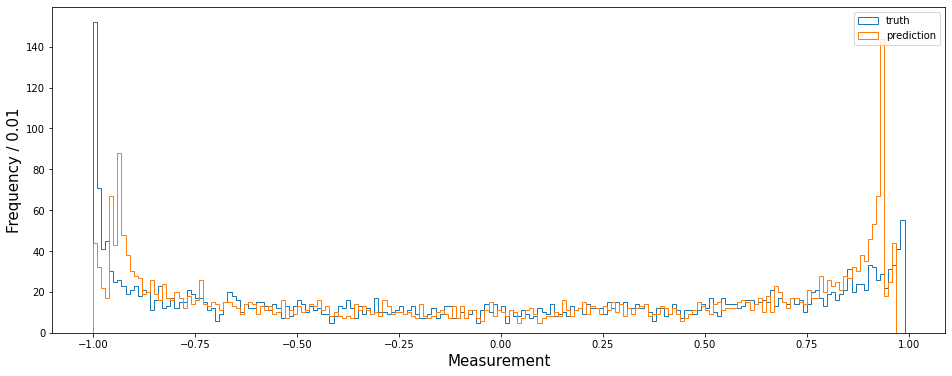

In [13]:
bins = np.arange(-1,1, 0.01)
fig = plt.figure(figsize=(16,6))
plt.hist(scaler_measurement.inverse_transform(series_y_valid.reshape(-1,1))[:,0], bins = bins, histtype = 'step', label = 'truth')
plt.hist(scaler_measurement.inverse_transform(predictions[:,0].reshape(-1,1))[:,0], bins = bins, histtype = 'step', label = 'prediction')
plt.xlabel('Measurement', size = 15)
plt.ylabel('Frequency / 0.01', size = 15)
plt.legend()

Let's try and plot the relative error distribution (truth - prediction)/truth! Here we hope for a slim delta-function-like distribution at 0. And if not, then perhaps a sharp gaussian around 0.

Text(0, 0.5, 'Frequency / 0.02')

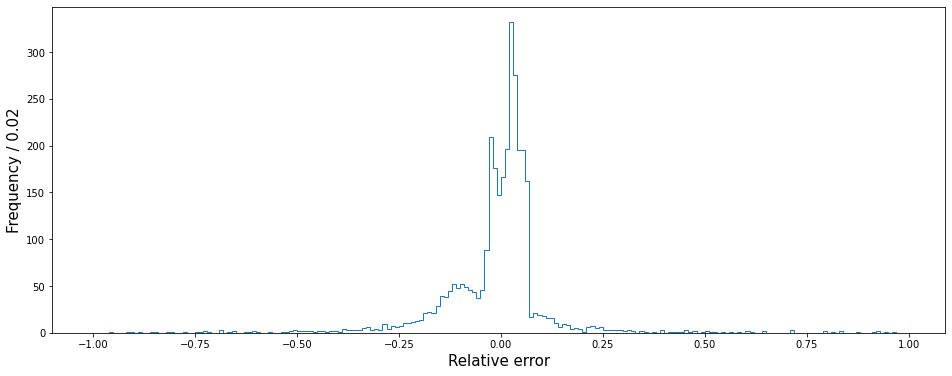

In [14]:
bins = np.arange(-1,1, 0.01)
fig = plt.figure(figsize=(16,6))
rel_error = (scaler_measurement.inverse_transform(series_y_valid.reshape(-1,1))[:,0] - scaler_measurement.inverse_transform(predictions[:,0].reshape(-1,1))[:,0])/scaler_measurement.inverse_transform(series_y_valid.reshape(-1,1))[:,0]
plt.hist(rel_error, bins = bins, histtype =  'step')
plt.xlabel('Relative error', size = 15)
plt.ylabel('Frequency / 0.02', size = 15)

Yeah.. Not too shappy! But we would have expected something as nice as this because we're simply learning sin(t \times k) in a super complicated way. Now, to get to know the LSTM better, try the following:

* Change the forecast_horizon to a larger number. Does the error change?
* Change the number of steps we look back in the past (e.g. sequence_length) does the error change?
* Try this on a Mackey sequence (see below). 
* Try to do the same but with a different RNN. Pssst: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
* For the cool people: Try to rewrite the above example such that it predicts more than a single value in the future, e.g. [t+forecast_horizon:(t+forecast_horizon + forecast_length)]!

In [15]:
Ntrain = 1000
Npredict = 10

In [16]:
def mackey_sequence(b=None, N=Ntrain+Npredict):
    """Create the Mackey-Glass series"""
    c = 0.2
    tau = 17
    n = 10

    yinit = np.array([0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076,
        1.1352, 1.1485, 1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756,
        1.0739, 1.0759])

    if b is None:
        b = np.zeros(N) + 0.1

    y = np.zeros(N)
    y[:yinit.shape[0]] = yinit

    for i in range(tau, N - 1):
        yi = y[i] - b[i] * y[i] + c * y[i - tau] / (1 + y[i - tau]**n)
        y[i + 1] = yi
    return y

In [17]:
data = mackey_sequence()